# Imports

We need a few libraries to help the development of this project.

In [1]:
import numpy as np
import pandas as pd
import math
import statistics as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Building the DataFrame

Now we create a dataframe with the information in the `match_data_v5.csv`, set the name of each column and drop the `matchID` and `empty` columns, since they are not relevant to the analysis.

In [2]:
data = pd.read_csv('match_data_v5.csv')
data.columns = ["matchID","blueTeamControlWardsPlaced","blueTeamWardsPlaced","blueTeamTotalKills","blueTeamDragonKills","blueTeamHeraldKills","blueTeamTowersDestroyed","blueTeamInhibitorsDestroyed","blueTeamTurretPlatesDestroyed","blueTeamFirstBlood","blueTeamMinionsKilled","blueTeamJungleMinions","blueTeamTotalGold","blueTeamXp","blueTeamTotalDamageToChamps",
                            "redTeamControlWardsPlaced","redTeamWardsPlaced","redTeamTotalKills","redTeamDragonKills","redTeamHeraldKills","redTeamTowersDestroyed","redTeamInhibitorsDestroyed","redTeamTurretPlatesDestroyed","redTeamMinionsKilled","redTeamJungleMinions","redTeamTotalGold","redTeamXp","redTeamTotalDamageToChamps","blueWin","empty"]
data = data.drop(columns=["matchID","empty"])
data.head()

,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,redTeamHeraldKills,redTeamTowersDestroyed,redTeamInhibitorsDestroyed,redTeamTurretPlatesDestroyed,redTeamMinionsKilled,redTeamJungleMinions,redTeamTotalGold,redTeamXp,redTeamTotalDamageToChamps,blueWin
0,2,23,4,2,0,0,0,7,0,388,...,0,2,0,1,400,94,29637,32613,27239,1
1,2,46,12,1,0,1,0,10,0,348,...,0,1,0,4,373,76,28970,30320,36585,0
2,2,19,13,0,0,0,0,11,0,331,...,0,2,0,3,340,84,30510,29464,42984,0
3,3,28,8,0,1,1,0,9,1,355,...,0,0,0,5,378,87,25157,31069,28229,0
4,3,30,11,1,1,1,0,7,0,370,...,0,1,0,5,382,96,26052,29475,19245,1


In [ ]:
data.describe()

In [ ]:
data.info()

Let's take a look at the data correlation to ensure everything is okay

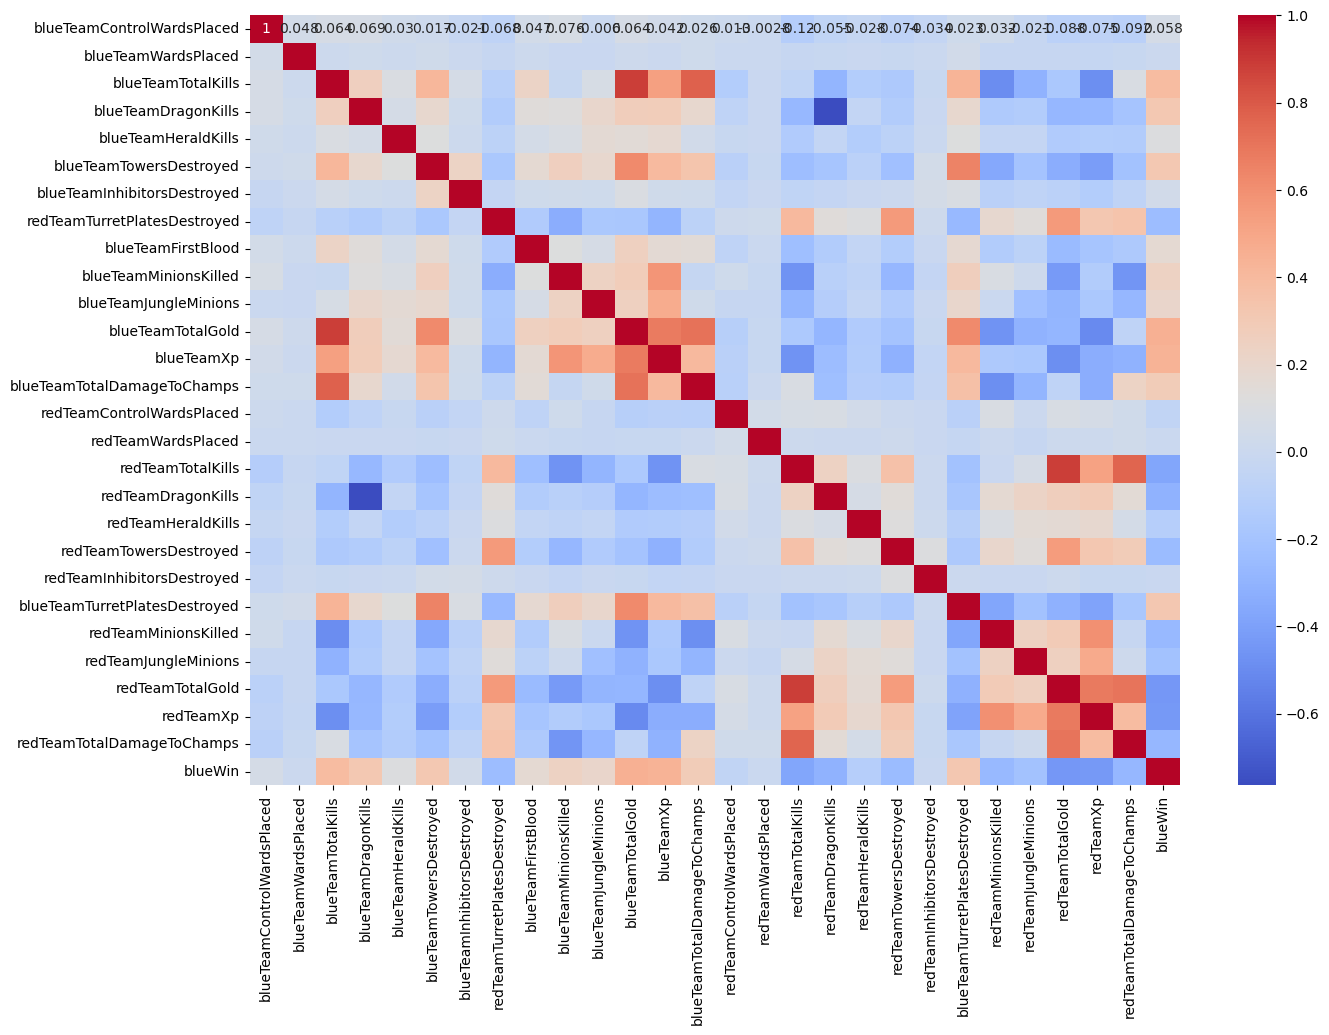

In [5]:
correlation = data.corr()
plt.figure(figsize=(15,10))
sb.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

Looking at this heatmap, we notice that there's a weird correlation between Turrets destroyed and their respective team turret plates destroyed. If a tower is destroyed within 14 minutes of the start of the game, said team also destroys 5 plates. This mean, the more turrets they destroy within 15 minutes, then the more turret plates they should've also destroyed. The heatmap seems to have both values swapped, as the correlation value between opposite team tower destroyed and plates destroyed is very high while for the same team is very low. Our though process is also reinforced by looking at the strangely high correlation between the turret plates destroyed and the enemy team's gold, because, since destroying turret plates give your team gold, then the high correlaiton should be between the same team's gold, not the other way around.

In [3]:
data.rename(columns={'blueTeamTurretPlatesDestroyed': 'redTeamTurretPlatesDestroyed', 'redTeamTurretPlatesDestroyed': 'blueTeamTurretPlatesDestroyed'}, inplace=True)

c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

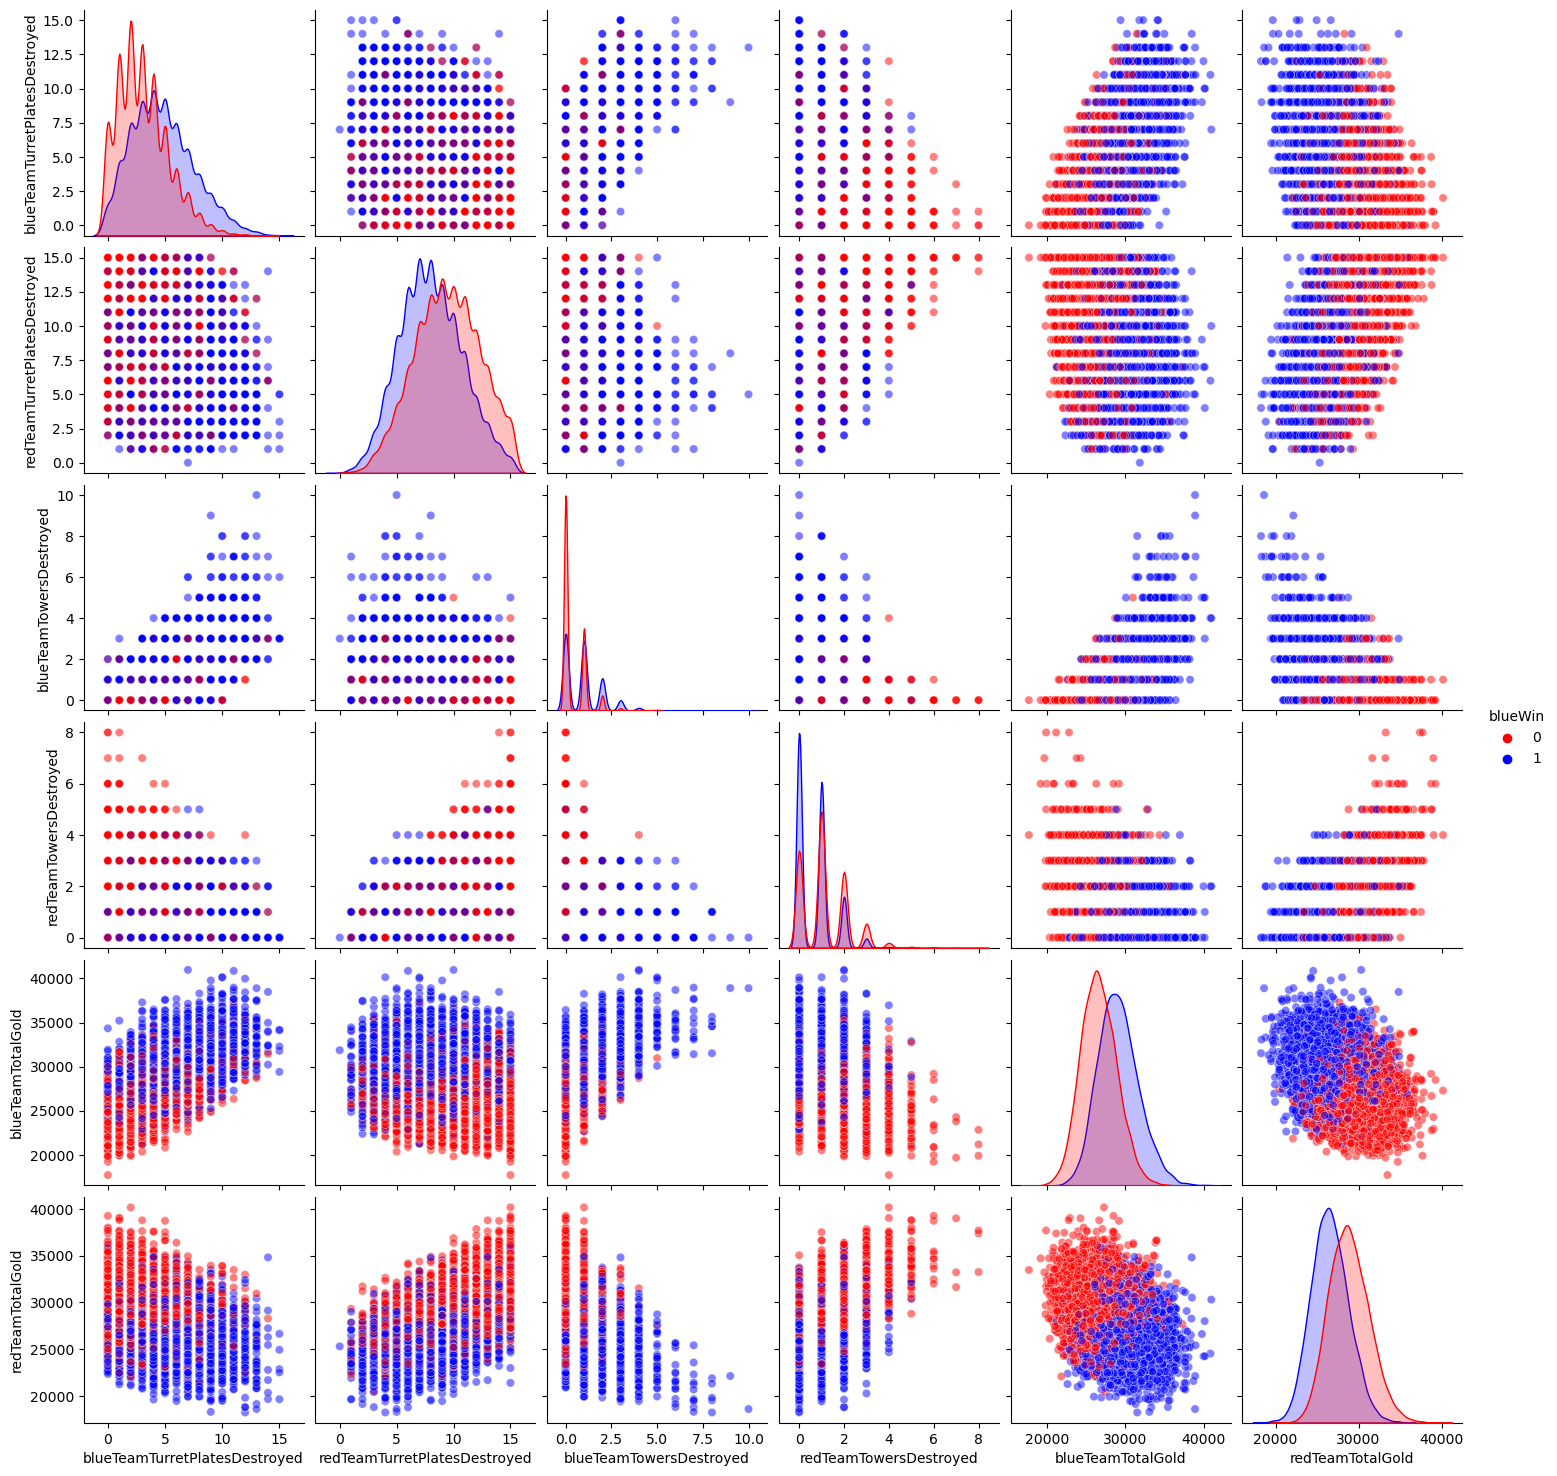

In [6]:
sample_size = data.__len__()
variables = ['blueTeamTurretPlatesDestroyed', 'redTeamTurretPlatesDestroyed', 'blueTeamTowersDestroyed', 'redTeamTowersDestroyed', 'blueTeamTotalGold', 'redTeamTotalGold','blueWin']

# Sample the data
sample = data.sample(sample_size)[variables]

palette = {0: 'red', 1: 'blue'}
sb.pairplot(sample, hue='blueWin', palette=palette, plot_kws={'alpha': 0.5})

By looking closely at these graphs we notice strange values for redTeamTurretPlatesDestroyed, because their value is greater than 15, which is the maximum amount of turret plates per game, so we must remove these values.

In [4]:
print("Size before removing wrong values: ", data.shape)

remove_extra_plates_red = data[(data['redTeamTurretPlatesDestroyed'] > 15)]
data.drop(remove_extra_plates_red.index, inplace=True)
remove_extra_plates_blue = data[(data['blueTeamTurretPlatesDestroyed'] > 15)]
data.drop(remove_extra_plates_blue.index, inplace=True)

print("Size after removing wrong values: ", data.shape)

Size before removing wrong values:  (24225, 28)
Size after removing wrong values:  (23685, 28)


Let's take a look at the amount of Heralds and Dragons killed to make sure they don't exceed the limit.

In [ ]:
sample_size = data.__len__()
variables = ['blueTeamHeraldKills', 'redTeamHeraldKills', 'blueTeamDragonKills', 'redTeamDragonKills', 'blueWin']

# Sample the data
sample = data.sample(sample_size)[variables]

palette = {0: 'red', 1: 'blue'}
sb.pairplot(sample, hue='blueWin', palette=palette, plot_kws={'alpha': 0.5})

c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiago\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

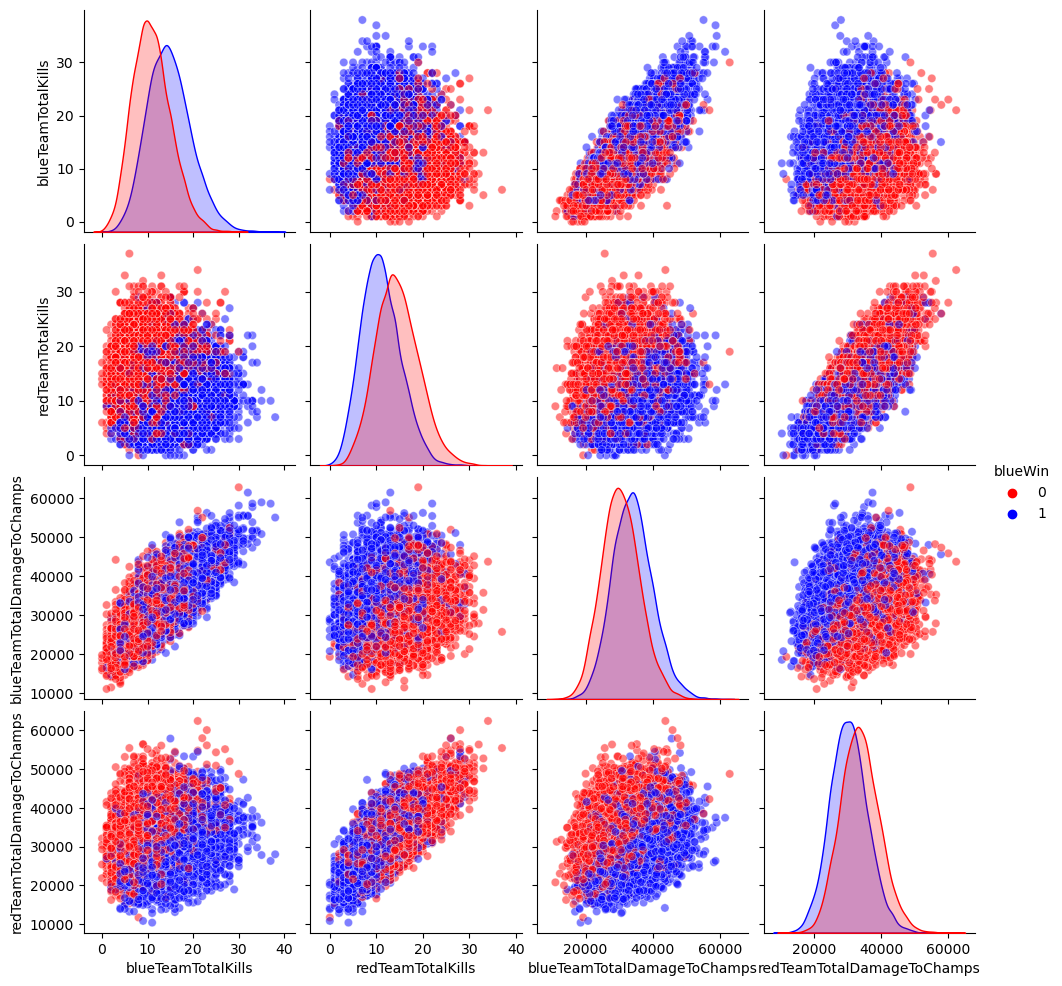

In [7]:
sample_size = data.__len__()
variables = ['blueTeamTotalKills', 'redTeamTotalKills', 'blueTeamTotalDamageToChamps', 'redTeamTotalDamageToChamps', 'blueWin']

# Sample the data
sample = data.sample(sample_size)[variables]

palette = {0: 'red', 1: 'blue'}
sb.pairplot(sample, hue='blueWin', palette=palette, plot_kws={'alpha': 0.5})

We are trying to find a correlation between game states and whether or not they lead to a victory.
In this case, `Red` means the `Blue` team lost, whereas `Blue` means the `Blue` team won.

From these graphs, we can see some contributing factors to a win:

- Total kills:
    If we compare `redTeamTotalKills` and `blueTeamTotalKills`, we can see that games are mostly won by the teams with more kills.
- Total Damage to Champions:
    Much like total kills, it appears as if the team with most total damage to champions tends to win the game.
    The graph comparing each team's total damage to champions is quite similar to the graph comparing total kills. This is because these two variables are very intertwined, since, generally, dealing damage to enemy champions may result in their death.

Now, we will create some violin plots to further analyze the data.

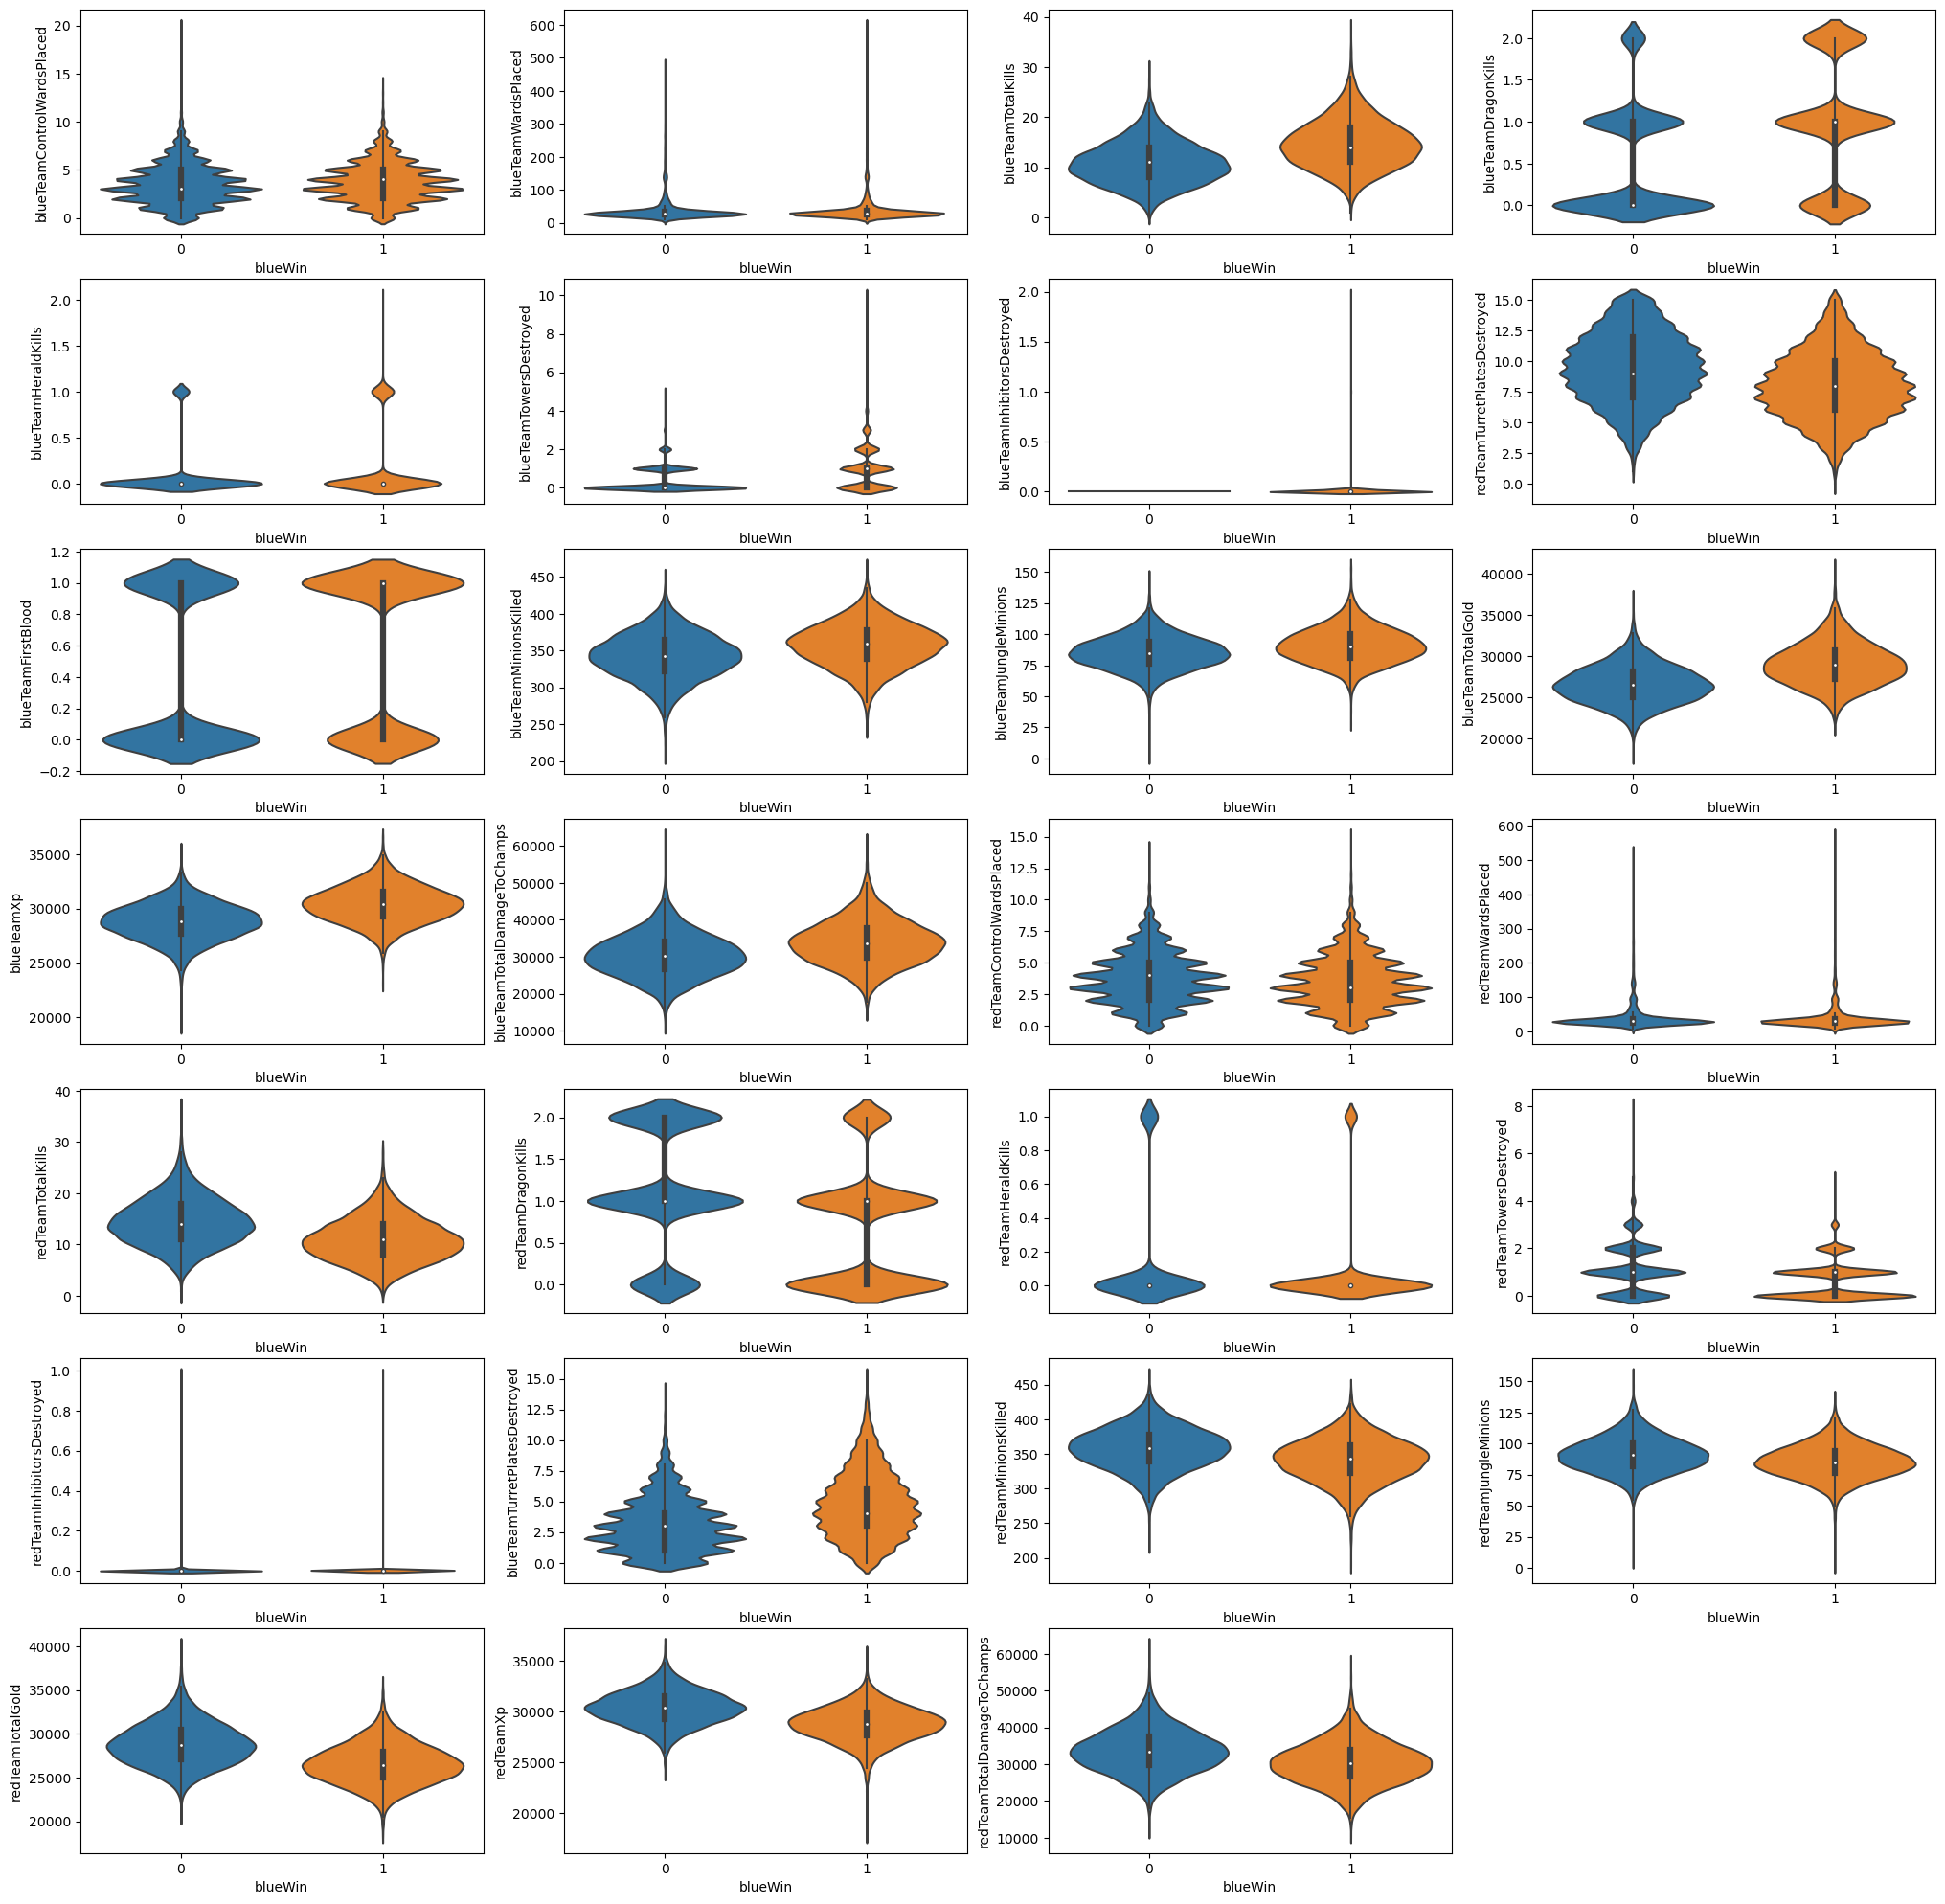

In [8]:
plt.figure(figsize=(25, 25))

num_columns = 4
num_rows = math.ceil(len(data.columns) / num_columns)

for column_index, column in enumerate(data.columns):
    if column == 'blueWin':
        continue
    plt.subplot(num_rows, num_columns, column_index + 1)
    sb.violinplot(x='blueWin', y=column, data=data)

# Classification

Now, we will start the classification process.

## Decision Tree Classifier

We are going to create a Decision Tree Classifier with the raw dataset we have, no additional performance boosters.

In [9]:
new_data = data.drop(columns=['blueWin'])
inputs = new_data.values
labels = data['blueWin'].values

(training_inputs, testing_inputs, training_labels, testing_labels) = train_test_split(inputs, labels, test_size=0.25, random_state=42) # 42 is the answer to everything

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_inputs, training_labels)
decision_tree_classifier.score(testing_inputs, testing_labels)

0.671563660925363

As we can see, we got an average score of about 66-67%. This isn't great. To improve it, we will select the most prominent features, and also use ensemble methods.

### Ensemble Method

Instead of using a single decision tree, we can use an ensemble of decision trees, such as a Random Forest or Gradient Boosting classifier. These methods often perform better than a single decision tree.

In [10]:
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(training_inputs, training_labels)
random_forest_classifier.score(testing_inputs, testing_labels)

0.7509287402904424

As we can see, with 100 estimators, we bumped the score to around 74-75%

### Feature Selection

Not all features are equally informative. We can use feature importance methods to select the most informative features to train our model.

In [11]:
# Get the feature importances
importances = random_forest_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(training_inputs.shape[1]):
    print(f"{new_data.columns[indices[f]]}: {importances[indices[f]]}")

blueTeamTotalGold: 0.10653042403804601
redTeamTotalGold: 0.10299752580528614
redTeamXp: 0.09294460423837869
blueTeamXp: 0.08699306089029626
blueTeamTotalKills: 0.05114987627796309
redTeamTotalDamageToChamps: 0.04969097027088787
blueTeamTotalDamageToChamps: 0.04862113448290429
redTeamTotalKills: 0.04574269725904794
redTeamMinionsKilled: 0.041659117362384715
blueTeamMinionsKilled: 0.03939131031802129
redTeamJungleMinions: 0.03640465000634588
blueTeamJungleMinions: 0.0363704613719911
redTeamWardsPlaced: 0.034428334456446
blueTeamWardsPlaced: 0.0339959778474205
blueTeamTurretPlatesDestroyed: 0.03047825713422298
blueTeamDragonKills: 0.029003957237418176
redTeamTurretPlatesDestroyed: 0.02603174136384375
blueTeamControlWardsPlaced: 0.023128668061597576
redTeamControlWardsPlaced: 0.0230694385744583
redTeamDragonKills: 0.018034490737917977
blueTeamTowersDestroyed: 0.016722448592228437
redTeamTowersDestroyed: 0.012483678620319058
blueTeamFirstBlood: 0.006311138234474694
blueTeamHeraldKills: 0.00

Let's stop and analyze this for a bit, in the context of the actual game.

Looking at the top of the feature importances list, we can see `blueTeamTotalGold` and `redTeamTotalGold`. This makes sense, because, in `League of Legends`, you kill minions, enemy champions, neutral objetives and so on, so you can earn more gold, which in turn gives you the ability to buy more items, which make you stronger. The stronger you are compared to your opponent, the better odds you have of winning the game.

Alternatively, let's look at the bottom of the list. We'll ignore `Inhibitors Destroyed` for now.
Both `First Blood` and `Herald Kills` seem not too indicative of whether or not a team wins the game.
Let's think why.

`First Blood` corresponds to the first kill in the game. This tends to happen very early on, especially since our dataset contains games from mid `emerald` to high `diamond`, ranks very high up in the ranked ladder, also known to have very aggressive and chaotic games. `First Blood`, compared to other kills, gives a bonus 100 gold on top of the 300 gold received for killing an enemy champion. Seeing as a game spans roughly 25-40 minutes, where each player will end up having around 15000 gold (depending on the position, supports don't usually have that much gold), it makes sense that 100 gold at the beggining of the game does not impact the outcome very significantly.

`Heralds`, on the other hand, after being placed on the map, can be very helpful to destroy towers, which in turn gives the team more gold and puts more pressure on the map for the enemy team. So why is it so low? Very much like `First Blood`, the `Herald` spawns on the map very early on in the game. 
Additionally, this variable can be misleading. `Herald Kills` represents the `Herald` **Kills**, not what you actually do **with** the `Herald`. 
There is much to consider here due to several factors:

- **Killing** the `Herald` itself does not give the team much of an advantage, it's what you do **with** it
- If you do not place the `Herald` on the map 4 minutes after killing it, that ability expires and you cannot summon it anymore
- Some `Herald` summons can be very bad, and thus not really help the team that summoned it
- The `Herald` disappears from the map at 19:55 minutes into the game, if in combat. If you kill it at exactly 19:55 minutes, you have until 23:55 minutes to spawn it. Our dataset only contains information on the first 15 minutes of the game. 

With this in mind, it would make sense that these 2 factors: `First Blood` and `Herald Kills` don't tells us a lot about who is going to win the game.

In [12]:
# Add InhibitorsDestroyed since they're important but underrepresented
top_features = ['redTeamInhibitorsDestroyed'] + ['blueTeamInhibitorsDestroyed'] + [new_data.columns[indices[i]] for i in indices[:22]]
data_top_features = data[top_features]

(training_inputs, testing_inputs, training_labels, testing_labels) = train_test_split(data_top_features.values, labels, test_size=0.25, random_state=42)

fs_random_forest_classifier = RandomForestClassifier(n_estimators=100)
fs_random_forest_classifier.fit(training_inputs, training_labels)
fs_random_forest_classifier.score(testing_inputs, testing_labels)

0.7521107733873691

In [13]:
scores = cross_val_score(random_forest_classifier, data_top_features.values, labels, cv=10)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.77247784 0.75643732 0.76065851 0.76192486 0.75685943 0.75295608
 0.74451014 0.73268581 0.74366554 0.73353041]
Mean cross-validation score:  0.751570592991683


Now, let's compare a simple Decision Tree Classifier with a Random Forest Classifier with feature selection

Average difference of scores between Random Forest and Decision Tree Classifiers:  0.08581560283687939


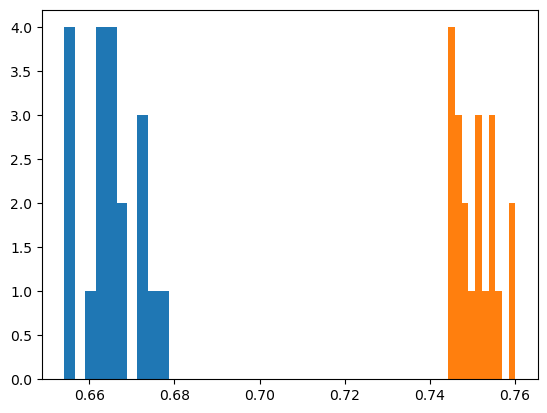

In [14]:
dtc_accuracies = []
rfc_accuracies = []

for repetition in range(20):
    # Create the training and test sets for each model
    (dtc_training_inputs,
     dtc_testing_inputs,
     dtc_training_labels,
     dtc_testing_labels) = train_test_split(inputs, labels, test_size=0.25)
    
    (rfc_training_inputs, 
     rfc_testing_inputs,
     rfc_training_labels, 
     rfc_testing_labels) = train_test_split(data_top_features.values, labels, test_size=0.25)

    # Create the classifiers
    decision_tree_classifier = DecisionTreeClassifier()
    random_forest_classifier = RandomForestClassifier(n_estimators=100)
    
    # Train the classifier on the training set
    decision_tree_classifier.fit(dtc_training_inputs, dtc_training_labels)
    random_forest_classifier.fit(rfc_training_inputs, rfc_training_labels)
    
    # Validate the classifier on the testing set using classification accuracy
    dtc_accuracy = decision_tree_classifier.score(dtc_testing_inputs, dtc_testing_labels)
    rfc_accuracy = random_forest_classifier.score(rfc_testing_inputs, rfc_testing_labels)

    dtc_accuracies.append(dtc_accuracy)
    rfc_accuracies.append(rfc_accuracy)

plt.hist(dtc_accuracies)
plt.hist(rfc_accuracies)

print("Average difference of scores between Random Forest and Decision Tree Classifiers: ", stats.mean(rfc_accuracies) - stats.mean(dtc_accuracies))

As we can see, the Random Forest Classifier with feature selection has, on average, 8% better accuracy than a simple Decision Tree Classifier, bumping up the 67% figure to around a 75%. 